In [28]:
%matplotlib inline
from math import pi
import openmc
import openmc.deplete
import matplotlib.pyplot as plt
from matplotlib.pyplot import Line2D

In [29]:
# Instantiate some Materials and register the appropriate Nuclides
u238 = openmc.Material(name='source')
u238.set_density('g/cm3', 10.29769)
u238.add_nuclide('U238', 1.)

helium = openmc.Material(name='sink')
helium.set_density('g/cm3', 0.001598)
helium.add_element('He', 2.4044e-4)
helium.depletable = True

# Define overall material
material = openmc.Materials([u238, helium])

In [30]:
# Define surfaces
width = 1.25984
height = 200
radius = 2
fuel_or = openmc.ZCylinder(r=0.39218, name='Fuel OR', boundary_type='reflective')
z_top = openmc.ZPlane(z0=height/2, name='Pin TOP', boundary_type='vacuum')
z_bot = openmc.ZPlane(z0=-height/2, name='Pin BOT', boundary_type='vacuum')
surf = openmc.Sphere(x0=10, r=radius, boundary_type = 'vacuum')

# Define cells
fuel = openmc.Cell(fill=uo2, region=-fuel_or & -z_top & +z_bot)
sink = openmc.Cell(fill=helium, region=-ofc_surf)

# Define overall geometry
geometry = openmc.Geometry([fuel, sink])

In [31]:
# Set material volume for depletion
fuel_vol = pi * fuel_or.r**2 * height
sink_vol = 4 / 3 * pi * radius**3 

In [32]:
# Instantiate a Settings object, set all runtime parameters, and export to XML
settings = openmc.Settings()
settings.batches = 100
settings.inactive = 10
settings.particles = 1000

# Create an initial uniform spatial source distribution over fissionable zones
bounds = [-0.62992, -0.62992, -100, 0.62992, 0.62992, 100]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
settings.source = openmc.source.Source(space=uniform_dist)

#Build the model
model = openmc.Model(geometry=geometry, materials=material, settings=settings)

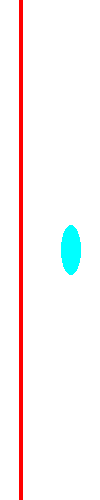

In [17]:
# Create plot
geometry.export_to_xml()
material.export_to_xml()
plot = openmc.Plot.from_geometry(geometry)
plot.basis = 'xz'
plot.width = (20,40)
plot.pixels = (100,500)
plot.color_by = 'material'
plot.colors = {u238:'red', helium:'cyan'}
openmc.plot_inline(plot)

# Standard depletion

In [33]:
u238.volume = fuel_vol
helium.volume = sink_vol
#Create depletion "operator"
chain_file = 'chain_simple.xml'
op = openmc.deplete.CoupledOperator(model, chain_file)
# Perform simulation using the predictor algorithm
time_steps = [1.0, 1.0, 1.0, 1.0, 1.0]  # days
power = 0  # W
integrator = openmc.deplete.PredictorIntegrator(op, time_steps, power, timestep_units='d')
integrator.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [34]:
# Open results file
results = openmc.deplete.Results("depletion_results.h5")

# Obtain U238 concentration as a function of time
n_u8_1 = results.get_atoms(u238, 'U238')[1]
n_u8_1_ofc = results.get_atoms(helium, 'U238')[1]



# MSR

In [45]:
# Re-create the depletion "operator"
op = openmc.deplete.CoupledOperator(model, chain_file)
#Create msr continuous instance
msr_c = openmc.deplete.msr.MsrContinuous(op, model)
# Cycle time as the time needed to circulate the all volume
cycle_time=1
msr_c.set_removal_rate('source', ['U'], 1/cycle_time, dest_mat = 'sink' )
# Pass the msr instance to the integrator object
integrator = openmc.deplete.PredictorIntegrator(op, time_steps, power, msr_continuous=msr_c,  timestep_units='d')
integrator.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

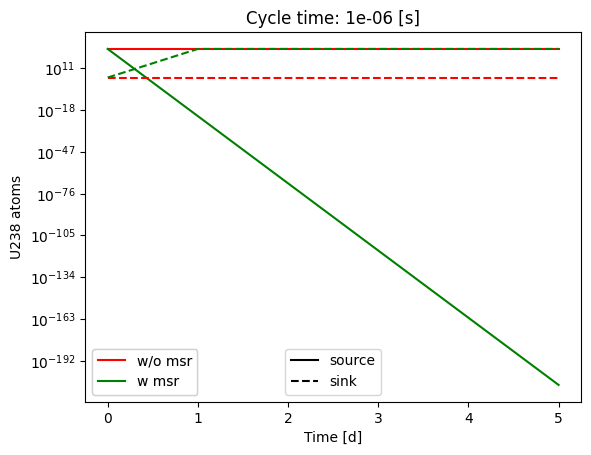

In [46]:
line1 = Line2D([0], [0], color='black')
line2 = Line2D([0], [0], linestyle='--', color='black')
labels = ['source', 'sink']

# Open results file
results = openmc.deplete.Results("depletion_results.h5")

# Obtain U238 concentration as a function of time
n_u8_2 = results.get_atoms(u238, 'U238')[1]
n_u8_2_ofc = results.get_atoms(helium, 'U238')[1]


fig, ax = plt.subplots()
ax.plot(time, n_u8_1, c='r', label="w/o msr")
ax.plot(time, n_u8_2, c='g', label="w msr")
ax.plot(time, n_u8_1_ofc, '--', c='r')
ax.plot(time, n_u8_2_ofc, '--', c='g')
ax.set_xlabel("Time [d]")
ax.set_ylabel("U238 atoms")
ax.set_yscale('log')
leg1=plt.legend([line1, line2],labels,loc='lower center')
leg2=plt.legend()
ax.add_artist(leg1)
ax.add_artist(leg2)
plt.title(f'Cycle time: {cycle_time} [s]')
plt.show()

